## Project: Style transfer using GAN
### MRI Image translation between T1 & T2 types using CycleGAN 


* In this Notebook we'll convert MRI Images from T1 type to T2 type and vice-versa using CycleGAN Network.
* Below is the result that we want to achieve using CycleGANs.

<center><b>Conversion of MRI from T1 to T2 type</b></center>

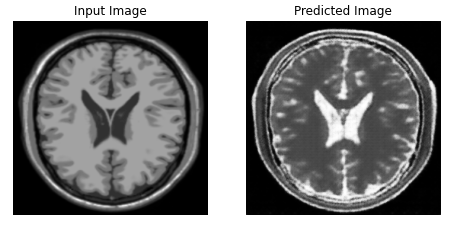

<center><b>Conversion of MRI from T2 to T1 type</b></center>

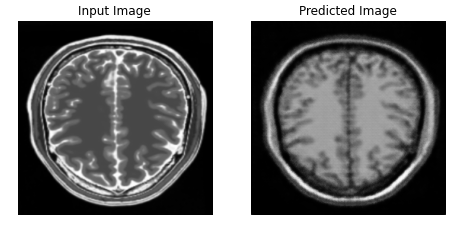

### Pipeline
The Sequence of the Project

1. Importing Libraries
2. Data Loading, Normalization and Visualization
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF

### Import Libraries


1.   numpy
2.   tensorflow
3.   matplotlib
4.   skimage







In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
# from keras.utils.vis_utils import plot_model
import imageio
import glob
from PIL import Image
from scipy import stats

### Data Loading and Visualization
1. Data Loading
2. Data Visualization

#### Data Loading

In [2]:
# Load all t1, t2 type images from the directories to separate numpy arrays

t1_file_list = glob.glob('TrainT1/*.png')
t1_images = np.array([np.array(Image.open(fname)) for fname in t1_file_list])

t2_file_list = glob.glob('TrainT2/*.png')
t2_images = np.array([np.array(Image.open(fname)) for fname in t2_file_list])

type(t1_images), t1_images.shape, type(t2_images), t2_images.shape

(numpy.ndarray, (43, 217, 181), numpy.ndarray, (46, 217, 181))

Declare Batch Size

In [3]:
BATCH_SIZE = 16

#### Data Normalization and Visualization of Images of T1, T2 types

In [4]:
# Check image pixel values range (0,255)

t1_images.shape, stats.describe(t1_images[0].reshape(-1))

((43, 217, 181),
 DescribeResult(nobs=39277, minmax=(0, 255), mean=80.62296000203682, variance=3636.5550823574226, skewness=-0.13515298795928143, kurtosis=-1.401094305094617))

In [5]:
# Normalize the images to [-1.0, 1.0]

t1_images = (t1_images/127.5)-1.0 
t1_images.shape, stats.describe(t1_images[0].reshape(-1))

((43, 217, 181),
 DescribeResult(nobs=39277, minmax=(-1.0, 1.0), mean=-0.36766305880755445, variance=0.22370196585051433, skewness=-0.13515298795928074, kurtosis=-1.4010943050946174))

Total 5842 Images of digit 4

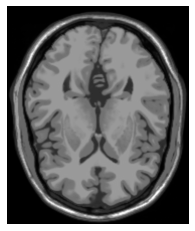

In [6]:
# Plot t1 sample Image

plt.imshow(t1_images[0], cmap='gray')
plt.axis('off')
plt.show()

In [7]:
# Check image pixel values range (0,255)

t2_images.shape, stats.describe(t2_images[0].reshape(-1))

((46, 217, 181),
 DescribeResult(nobs=39277, minmax=(0, 255), mean=69.18226952160298, variance=4788.129293525179, skewness=0.7951077765590137, kurtosis=-0.14715497369592878))

In [8]:
# Normalize the images to [-1.0, 1.0]

t2_images = (t2_images/127.5)-1.0
t2_images.shape, stats.describe(t2_images[0].reshape(-1))

((46, 217, 181),
 DescribeResult(nobs=39277, minmax=(-1.0, 1.0), mean=-0.45739396453644726, variance=0.2945408254379194, skewness=0.7951077765590141, kurtosis=-0.147154973695927))

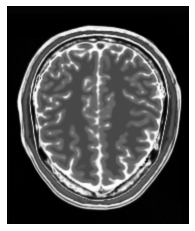

In [9]:
# Plot t2 sample Image

plt.imshow(t2_images[0], cmap='gray')
plt.axis('off')
plt.show()

### Data Preprocessing
1.   Data Resizing
2.   Data Reshaping and flip images left to right
3.   Batch and Shuffle Data

#### Resize Images to size (256, 256)

In [10]:
t1_data = np.zeros((t1_images.shape[0], 256, 256))
for index, img in enumerate(t1_images):
    t1_data[index, :, :] = resize(img, (256, 256))
t1_data.shape

(43, 256, 256)

In [11]:
t2_data = np.zeros((t2_images.shape[0], 256, 256))
for index, img in enumerate(t2_images):
    t2_data[index, :, :] = resize(img, (256, 256))
t2_data.shape

(46, 256, 256)

#### Reshape Images to (256, 256, 1) with float pixel values

In [12]:
t1_data = t1_data.reshape(t1_data.shape[0], 256, 256, 1).astype('float32')
t2_data = t2_data.reshape(t2_data.shape[0], 256, 256, 1).astype('float32')
t1_data.shape, t2_data.shape

((43, 256, 256, 1), (46, 256, 256, 1))

#### Flip images, Batch and shuffle the data

In [13]:
# Tested CycleGAN network with and without preprocessing the images with random right left flip
# The results were better when dataset images were NOT flipped

# t1_data = tf.data.Dataset.from_tensor_slices(t1_data).map(lambda img:tf.image.random_flip_left_right(img)).shuffle(t1_images.shape[0], seed=42).batch(BATCH_SIZE)
# t2_data = tf.data.Dataset.from_tensor_slices(t2_data).map(lambda img:tf.image.random_flip_left_right(img)).shuffle(t2_images.shape[0], seed=42).batch(BATCH_SIZE)

t1_data = tf.data.Dataset.from_tensor_slices(t1_data).shuffle(t1_images.shape[0], seed=42).batch(BATCH_SIZE)
t2_data = tf.data.Dataset.from_tensor_slices(t2_data).shuffle(t2_images.shape[0], seed=42).batch(BATCH_SIZE)
t1_data, t2_data

(<BatchDataset shapes: (None, 256, 256, 1), types: tf.float32>,
 <BatchDataset shapes: (None, 256, 256, 1), types: tf.float32>)

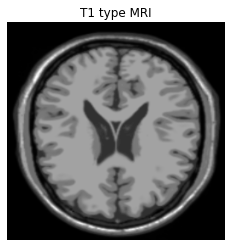

In [14]:
sample_t1_data = next(iter(t1_data))
plt.imshow(sample_t1_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('T1 type MRI')
plt.axis('off')
plt.show()

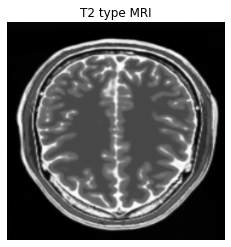

In [15]:
sample_t2_data = next(iter(t2_data))
plt.imshow(sample_t2_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('T2 type MRI')
plt.axis('off')
plt.show()

### Model Building
1. Instance Normalization
2. Downsampling, Upsampling and Unet
3. Generator Building using Unet
4. Discriminator Building

#### Instance Normalization
Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

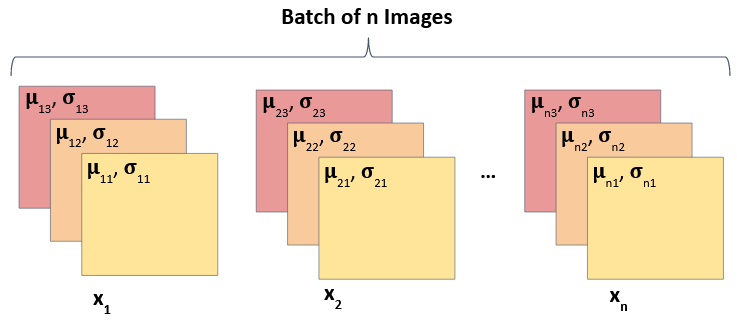

In [16]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling
Downsampling is performed using the Convolution, leading to reduce in dimensions.

In [17]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Upsampling
Upsampling is a result of Transposed Convolution, where dimension of image are increased.

In [18]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Unets
Unets takes Image as an input and translate it into another Image. <p>
To do this they first use Downsampling on Input Image to learn the latent characteristics of Input Image and then use Upsampling to use this knowledge to Translate it into another Image. <p>
Let's understand it through the below image.
* Note: Below Image is an example of U-net, The U-net used in solution is not of same size(s)

<center>

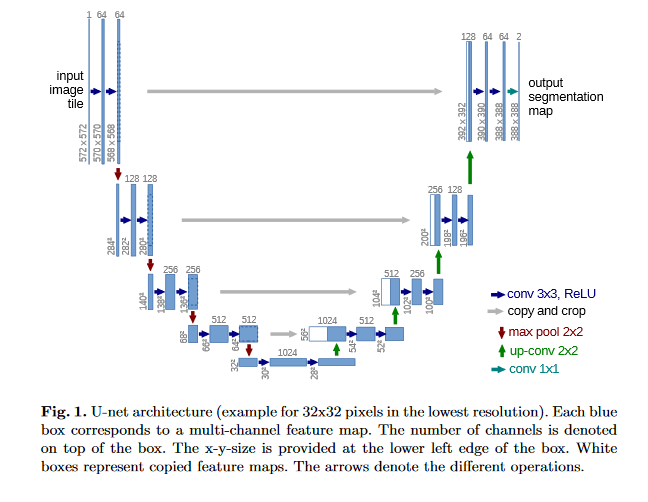

</center>

In [19]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(64, 4, False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(128, 4), # (bs, 32, 32, 128)
        downsample(128, 4), # (bs, 16, 16, 128)
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(128, 4), # (bs, 4, 4, 128)
        downsample(128, 4), # (bs, 2, 2, 128)
        downsample(128, 4)  # (bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(128, 4, True), # (bs, 2, 2, 256)
        upsample(128, 4, True), # (bs, 4, 4, 256)
        upsample(128, 4, True), # (bs, 8, 8, 128)
        upsample(128, 4, True), # (bs, 16, 16, 128)
        upsample(128, 4, True), # (bs, 32, 32, 128)
        upsample(128, 4), # (bs, 64, 64, 128)
        upsample(64, 4)   # (bs, 128, 128, 64)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Generator
Generator is a Unet Network here since We want to translate One type of MRI Image (T1) into Another type of Image (T2).

In [20]:
generator_g = unet_generator()
generator_f = unet_generator()

Let's also visualize one of our Generator Models since Both our Generators have same architecture.

Notice How the dimension reduces first but then increases.

In [21]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 128)  262400      sequential_1[0][0]               
______________________________________________________________________________________________

#### Discriminator
Discriminator is a traditional CNN, which we use to classify the Images. It only uses Downsampling hence.

Both Discriminators have same architecture

In [22]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (256, 256, 1)
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    down4 = downsample(256, 4)(down3) # (bs, 16, 16, 256)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 18, 18, 256)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 15, 15, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 17, 17, 512)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 14, 14, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [23]:
discriminator_x = discriminator()
discriminator_y = discriminator()

Have a look at Discriminator's architecture, Notice that The Dimensions are reducing overall at the end since it's a classifier and only Convolution layers are being used.

In [24]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential_30 (Sequential)   (None, 128, 128, 64)      1024      
_________________________________________________________________
sequential_31 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_32 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
sequential_33 (Sequential)   (None, 16, 16, 256)       1049088   
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 18, 18, 256)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 512)       2097

### Model Training
1. Declare Loss type
2. Calculate Discriminator Loss
3. Calculate Generator Loss
4. Cycle Loss
5. Identity Loss
6. Optimizer
7. Checkpoint Initialization
8. Training Flow

Check output of Untrained Generator models which should be a random noise

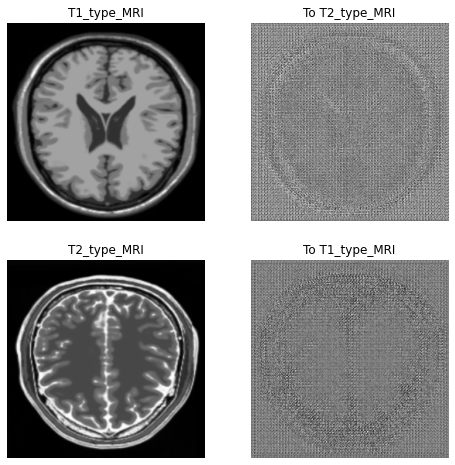

In [25]:
to_t2_data = generator_g(sample_t1_data)
to_t1_data = generator_f(sample_t2_data)
plt.figure(figsize=(8, 8))

imgs = [sample_t1_data, to_t2_data, sample_t2_data, to_t1_data]
title = ['T1_type_MRI', 'To T2_type_MRI', 'T2_type_MRI', 'To T1_type_MRI']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Declare Loss as Binary Cross Entropy
Since Our Discriminator is a classifier

In [26]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss
It consists of two types of losses
1.    Loss on Real Data
2.    Loss on Fake Data

In [27]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data

In [28]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

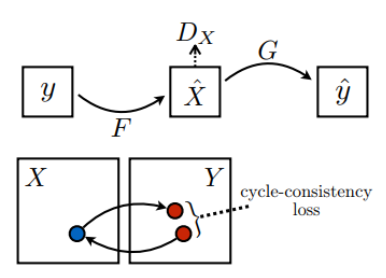

In [29]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

#### Identity Loss
When we provide input image to the Generator such that no translation is needed because the Image is already transformed. Here also we take L1 Loss between Input and Output Image.

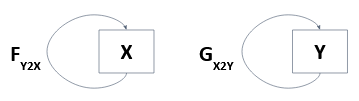

In [30]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

#### Optimizer 
We use Adam Optimizer to update weights which is a good optimizer to achieve quick learning.

In [31]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

We'll train out Model for 100 Epochs

In [32]:
EPOCHS = 100

#### Checkpoint Initialization
Initialize checkpoints to save models

In [33]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Function to show Images output by Generators while Training

In [34]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(16, 8))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#### Training FLow
Below Function performs one Flow of Batch Training <p>
Notice that Identity Loss and Cycle Loss are only used in training Generator and not Discriminator

Sequence of Training Flow


1.   Generate Fake Y and Cycled X
2.   Generate Fake X and Cycled Y
3.   Generate Fake Images through G and F for Identity Loss.
4.   Calculate Discriminator Loss for Disc X and Disc Y on Fake Data for Generator Training.
5.   Calculate Generator Loss on Discriminator.
6.   Calculate Cycled Loss on Cycled Images from step 1 and 2.
7.   Calculate Total Generator Loss - Disc Loss + Cycled Loss + Identity Loss
8.   Calculate Discriminator Loss on both Fake and Real Images for Disc X and Y for Disc Training.
9.   Calculate the Gradients and update the weight and bias of models.



In [35]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

#### Train the CycleGAN Model for several Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generators are getting better at producing realistic images epoch by epoch

In [ ]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((t1_data, t2_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Generating a GIF for visualization of Results
Notice the Quality of results we are getting.

In [37]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [38]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ta7ex2qd
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ta7ex2qd
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)